In [ ]:
import nfl_data_py as nfl
import  psycopg2
from psycopg2 import sql
from RawLoad import loadAll, loadYears
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF


pd.set_option("display.max_rows", None)     # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 2000)        # Prevent line wrapping
pd.set_option("display.max_colwidth", None) # Don't truncate cell conte

In [3]:
df = pd.read_pickle('C:/Code/Git Repositories/Football/rawdata_clean.pkl')


In [14]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop rows with missing data across all columns
    df = df.dropna()
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,game_id,home_team,home_score,away_team,away_score,season,week,hqb1,hqb1_passing_epa,hqb1_completions,hqb1_attempts,hqb1_passing_yards,hqb1_passing_tds,hqb1_interceptions,hqb1_sacks,hqb1_sack_yards,hqb1_passing_first_downs,hrb1,hrb1_rushing_epa,hrb1_rushing_yards,hrb1_rushing_fumbles,hrb1_rushing_fumbles_lost,hrb1_receiving_epa,hrb1_receiving_yards_after_catch,hrb1_rushing_tds,hwr1,hwr1_receiving_epa,hwr1_receptions,hwr1_targets,hwr1_receiving_tds,hwr1_receiving_fumbles,hwr1_receiving_fumbles_lost,hwr1_receiving_first_downs,hwr1_receiving_yards,hwr1_receiving_yards_after_catch,hwr2,hwr2_receiving_epa,hwr2_receptions,hwr2_targets,hwr2_receiving_tds,hwr2_receiving_fumbles,hwr2_receiving_fumbles_lost,hwr2_receiving_first_downs,hwr2_receiving_yards,hwr2_receiving_yards_after_catch,hte1,hte1_receiving_epa,hte1_receptions,hte1_targets,hte1_receiving_tds,hte1_receiving_fumbles,hte1_receiving_fumbles_lost,hte1_receiving_first_downs,hte1_receiving_yards,hte1_receiving_yards_after_catch,hdl1,hdl1_tackles,hdl1_tackles_solo,hdl1_tackles_with_assist,hdl1_tackles_for_loss,hdl1_tackles_for_loss_yards,hdl1_fumbles_forced,hdl1_sacks,hdl1_sack_yards,hdl1_qb_hits,hdl1_interceptions,hdl1_interception_yards,hdl2,hdl2_tackles,hdl2_tackles_solo,hdl2_tackles_with_assist,hdl2_tackles_for_loss,hdl2_tackles_for_loss_yards,hdl2_fumbles_forced,hdl2_sacks,hdl2_sack_yards,hdl2_qb_hits,hdl2_interceptions,hdl2_interception_yards,hdl3,hdl3_tackles,hdl3_tackles_solo,hdl3_tackles_with_assist,hdl3_tackles_for_loss,hdl3_tackles_for_loss_yards,hdl3_fumbles_forced,hdl3_sacks,hdl3_sack_yards,hdl3_qb_hits,hdl3_interceptions,hdl3_interception_yards,hdl4,hdl4_tackles,hdl4_tackles_solo,hdl4_tackles_with_assist,hdl4_tackles_for_loss,hdl4_tackles_for_loss_yards,hdl4_fumbles_forced,hdl4_sacks,hdl4_sack_yards,hdl4_qb_hits,hdl4_interceptions,hdl4_interception_yards,hdb1,hdb1_tackles,hdb1_tackles_solo,hdb1_tackles_with_assist,hdb1_tackles_for_loss,hdb1_tackles_for_loss_yards,hdb1_fumbles_forced,hdb1_sacks,hdb1_sack_yards,hdb1_qb_hits,hdb1_interceptions,hdb1_interception_yards,hdb2,hdb2_tackles,hdb2_tackles_solo,hdb2_tackles_with_assist,hdb2_tackles_for_loss,hdb2_tackles_for_loss_yards,hdb2_fumbles_forced,hdb2_sacks,hdb2_sack_yards,hdb2_qb_hits,hdb2_interceptions,hdb2_interception_yards,hdb3,hdb3_tackles,hdb3_tackles_solo,hdb3_tackles_with_assist,hdb3_tackles_for_loss,hdb3_tackles_for_loss_yards,hdb3_fumbles_forced,hdb3_sacks,hdb3_sack_yards,hdb3_qb_hits,hdb3_interceptions,hdb3_interception_yards,hdb4,hdb4_tackles,hdb4_tackles_solo,hdb4_tackles_with_assist,hdb4_tackles_for_loss,hdb4_tackles_for_loss_yards,hdb4_fumbles_forced,hdb4_sacks,hdb4_sack_yards,hdb4_qb_hits,hdb4_interceptions,hdb4_interception_yards,hlb1,hlb1_tackles,hlb1_tackles_solo,hlb1_tackles_with_assist,hlb1_tackles_for_loss,hlb1_tackles_for_loss_yards,hlb1_fumbles_forced,hlb1_sacks,hlb1_sack_yards,hlb1_qb_hits,hlb1_interceptions,hlb1_interception_yards,hlb2,hlb2_tackles,hlb2_tackles_solo,hlb2_tackles_with_assist,hlb2_tackles_for_loss,hlb2_tackles_for_loss_yards,hlb2_fumbles_forced,hlb2_sacks,hlb2_sack_yards,hlb2_qb_hits,hlb2_interceptions,hlb2_interception_yards,hlb3,hlb3_tackles,hlb3_tackles_solo,hlb3_tackles_with_assist,hlb3_tackles_for_loss,hlb3_tackles_for_loss_yards,hlb3_fumbles_forced,hlb3_sacks,hlb3_sack_yards,hlb3_qb_hits,hlb3_interceptions,hlb3_interception_yards,aqb1,aqb1_passing_epa,aqb1_completions,aqb1_attempts,aqb1_passing_yards,aqb1_passing_tds,aqb1_interceptions,aqb1_sacks,aqb1_sack_yards,aqb1_passing_first_downs,arb1,arb1_rushing_epa,arb1_rushing_yards,arb1_rushing_fumbles,arb1_rushing_fumbles_lost,arb1_receiving_epa,arb1_receiving_yards_after_catch,arb1_rushing_tds,awr1,awr1_receiving_epa,awr1_receptions,awr1_targets,awr1_receiving_tds,awr1_receiving_fumbles,awr1_receiving_fumbles_lost,awr1_receiving_first_downs,awr1_receiving_yards,awr1_receiving_yards_after_catch,awr2,awr2_receiving_epa,awr2_receptions,awr2_targets,awr2_receiving_tds,awr2_receiving_fumbles,awr2_receiving_fumbles_lost,awr2_recei

In [ ]:
def scale_and_fit(scaler, grid, model_name: str, X_train, y_train):
    
    pipe = Pipeline([('scaler', scaler), (model_name, grid)])
    pipe.fit(X_train, y_train)
    pipe_model = pipe.named_steps[model_name]
    print(f'{model_name} Training score: {pipe.score(X_train, y_train)}')
    # To see coefficients with their feature names:
    coef_series = pd.Series(pipe_model.coef_, index=X_train.columns)
    print(coef_series.sort_values(ascending=False))

    return pipe

def xgb_scale_and_fit(grid, model_name: str, X_train, y_train):
    
    pipe = Pipeline([(model_name, grid)])
    pipe.fit(X_train, y_train)
    print(f'{model_name} Training score: {pipe.score(X_train, y_train)}')

    return pipe

def metrics(yhat, X_test, y_test, pipe):
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    mae = mean_absolute_error(y_test, yhat)
    score = pipe.score(X_test, y_test)
    return print(f'MAE: {mae}\nRMSE: {rmse}\nTesting Score: {score}')

# def create_vif(data: pd.DataFrame) -> pd.DataFrame:

#     num_cols = data.select_dtypes(['float64','int64'])
#     X = num_cols
#     values = [VIF(X, i) for i in range(1, X.shape[1])]
#     vif_score = pd.DataFrame({'vif': values, "columns": X.columns[1:]})

#     return vif_score

# def create_vif_recursive(new_vif_data: pd.DataFrame, data: pd.DataFrame) -> pd.DataFrame:

#     columns = new_vif_data['columns']
#     column_values = columns.values
#     X = data[columns]
#     values = [VIF(X, i) for i in range(1, X.shape[1])]
#     vif_score = pd.DataFrame({'vif': values, "columns": X.columns})

#     print(f'New VIF Scores:\n{vif_score}')
#     return vif_score

# def prune_vif(vif_data: pd.DataFrame, cutoff: int = 10) -> pd.DataFrame:

#     max_score = vif_data['vif'].max()

#     if cutoff > max_score:
#         print('No Multicollinearity found or your threshold has been met.')
#         return vif_data.sort_values(by='columns').reset_index()
#     else:
#         vif_data = vif_data[vif_data['vif'] <= cutoff]
#         return vif_data.sort_values(by='columns').reset_index()

        
    

# def tune_vif_recursive(data: pd.DataFrame, vif_data: pd.DataFrame, depth: int = 0, max_depth: int = 5) -> pd.DataFrame:
#     print(f'Recurssion depth: {depth}')
#     print(f'Old VIF scores:\n{vif_data}')
#     if depth > max_depth:
#         print("Max recursion depth reached. Stopping.")
#         return vif_data

#     max_score = vif_data['vif'].max()
#     cutoff = 10

#     print(max_score)
#     if cutoff > max_score:
#         print('No Multicollinearity found.')
#         return vif_data
#     else:
#         to_drop = vif_data.sort_values('vif', ascending=False).iloc[0]['columns']
#         print(f'Dropping: {to_drop} with VIF: {max_score}')
#         print(f'Inside recurssion')
#         vif_data = vif_data[vif_data['columns'] != to_drop]
#         new_vif_data = create_vif_recursive(new_vif_data=vif_data, data=data)
#         return tune_vif_recursive(vif_data=new_vif_data, depth=depth+1, data=data)
  
    


In [ ]:
# vif_scores = create_vif(df_clean)
# print(f'VIF Inital: {vif_scores}')




c:\Users\javen\miniconda3\envs\football\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Inital:             vif                           columns
0           inf                        away_score
1    133.123672                            season
2      4.514181                              week
3     11.449131                  hqb1_passing_epa
4    161.124275                  hqb1_completions
5    175.999408                     hqb1_attempts
6    171.990121                hqb1_passing_yards
7     15.197726                  hqb1_passing_tds
8      8.441261                hqb1_interceptions
9     81.690207                        hqb1_sacks
10    67.563777                   hqb1_sack_yards
11   119.707756          hqb1_passing_first_downs
12     2.840399                  hrb1_rushing_epa
13    10.408999                hrb1_rushing_yards
14     3.496619              hrb1_rushing_fumbles
15     3.413537         hrb1_rushing_fumbles_lost
16     1.502974                hrb1_receiving_epa
17     2.493183  hrb1_receiving_yards_after_catch
18     3.046567                  hrb1_

In [ ]:
# tuned_vif_scores = prune_vif(vif_data=vif_scores, cutoff=10)
# non_colinear_cols = tuned_vif_scores['columns']
# print(f'Tuned VIF Scores:\n{tuned_vif_scores}')

Tuned VIF Scores:
     index       vif                           columns
0      259  1.261865               adb1_fumbles_forced
1      264  1.800306           adb1_interception_yards
2      263  2.489912                adb1_interceptions
3      262  2.120766                      adb1_qb_hits
4      261  5.116889                   adb1_sack_yards
5      260  5.928196                        adb1_sacks
6      257  2.610954             adb1_tackles_for_loss
7      258  1.996057       adb1_tackles_for_loss_yards
8      270  1.263067               adb2_fumbles_forced
9      275  1.754539           adb2_interception_yards
10     274  2.377000                adb2_interceptions
11     273  1.803612                      adb2_qb_hits
12     272  5.283978                   adb2_sack_yards
13     271  5.796975                        adb2_sacks
14     268  2.335205             adb2_tackles_for_loss
15     269  1.896567       adb2_tackles_for_loss_yards
16     281  1.196391               adb3_fumbles

In [36]:
df_clean['margin'] = df_clean['home_score'] - df_clean['away_score']
data = df_clean.drop(columns=['winner', 'home_score', 'away_score'])

top_n = 250
corr_with_margin = df_clean.corr()['margin'].sort_values(key=abs, ascending=False)
top_n_features = list(corr_with_margin.index[:top_n])

top_n_df = df_clean[top_n_features]
top_n_df = top_n_df.drop(columns=['home_score', 'away_score'])

X = data.select_dtypes(include=['float64','int64'])
X = X.drop(columns='margin')
y = data['margin']

# X = data[non_colinear_cols]
# y = data['margin']

rand_num = int(np.random.rand() * 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=.2)
print(f'random state: {rand_num}')


C:\Users\javen\AppData\Local\Temp\ipykernel_5732\3018392158.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_margin = df_clean.corr()['margin'].sort_values(key=abs, ascending=False)


random state: 69


In [37]:

X = df_clean[non_colinear_cols]
y = df_clean['margin']

Lasso_model = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], cv=5)
scaler = StandardScaler()
model_name = 'LassoCV'

lasso_pipe = scale_and_fit(scaler=scaler, X_train=X_train, y_train=y_train, model_name=model_name, grid=Lasso_model)

lasso_yhat = lasso_pipe.predict(X_test)
metrics(lasso_yhat, X_test, y_test, lasso_pipe)

LassoCV Training score: 0.8117526401240841
hqb1_passing_epa                    4.742472
hqb1_passing_tds                    2.893591
hrb1_rushing_tds                    2.101023
hrb1_rushing_epa                    1.351953
hlb2_interceptions                  0.381493
hdb2_interceptions                  0.362516
hdb1_fumbles_forced                 0.351580
hdl2_sack_yards                     0.350761
adl2_tackles                        0.338884
hdb1_interception_yards             0.332764
hdl1_sack_yards                     0.305148
adb1_tackles                        0.286581
hrb1_rushing_yards                  0.281942
hdl1_fumbles_forced                 0.278408
hlb1_fumbles_forced                 0.262418
hdb2_interception_yards             0.259752
hdb3_interceptions                  0.256234
hdl3_interceptions                  0.227048
hdl2_interception_yards             0.226969
hlb3_fumbles_forced                 0.179932
ate1_targets                        0.176144
hlb1_interce

In [38]:
ridge_cv = RidgeCV(alphas=[.1, 1.0, 10, 100])
scaler = StandardScaler()
model_name = 'RidgeCV'

ridge_pipe = scale_and_fit(scaler=scaler, grid=ridge_cv, model_name=model_name, X_train=X_train, y_train=y_train)
ridge_yhat = ridge_pipe.predict(X_test)
metrics(yhat=ridge_yhat, X_test=X_test, y_test=y_test, pipe=ridge_pipe)


RidgeCV Training score: 0.8226830639336749
hqb1_passing_epa                    3.654467
hqb1_passing_tds                    2.711324
hrb1_rushing_tds                    2.077116
hrb1_rushing_epa                    1.471877
hqb1_sacks                          0.749030
hqb1_passing_yards                  0.699349
hqb1_passing_first_downs            0.619663
hdb3_sacks                          0.618501
hdb2_interceptions                  0.502079
hlb2_interceptions                  0.471846
hdb1_fumbles_forced                 0.470949
hdb3_interceptions                  0.433449
hrb1_rushing_fumbles                0.432260
hdl3_sacks                          0.408280
hwr1_receiving_tds                  0.399028
hdb1_interception_yards             0.397573
hdl1_fumbles_forced                 0.392959
hlb1_sacks                          0.382433
aqb1_passing_first_downs            0.379824
hte1_receiving_tds                  0.361288
hdb4_sacks                          0.357476
hdl2_interce

In [ ]:

elastic_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9, 1.0], alphas=[0.01, 0.1, 1, 10], cv=5)
# grid = GridSearchCV(Lasso_model, param_grid=param_grid, cv=5)
scaler = StandardScaler()
model_name = 'ElasticNetCV'

elastic_pipe = scale_and_fit(scaler=scaler, X_train=X_train, y_train=y_train, model_name=model_name, grid=elastic_model)


yhat = elastic_pipe.predict(X_test)
metrics(yhat, X_test, y_test, elastic_pipe)


ElasticNetCV Training score: 0.8166112132412138
hqb1_passing_epa                    3.631356
hqb1_passing_tds                    2.655917
hrb1_rushing_tds                    2.024484
hrb1_rushing_epa                    1.314266
hlb2_interceptions                  0.421579
hdb2_interceptions                  0.415893
hdb1_fumbles_forced                 0.385900
hdb1_interception_yards             0.383350
hwr1_receiving_tds                  0.372435
hqb1_passing_yards                  0.367263
hdl1_fumbles_forced                 0.359069
hqb1_passing_first_downs            0.344284
hdb2_interception_yards             0.336388
hdl1_sack_yards                     0.332240
adl2_tackles                        0.331868
adb1_tackles                        0.324697
hdl2_sack_yards                     0.321159
hdb3_interceptions                  0.313258
hlb1_fumbles_forced                 0.291716
hte1_receiving_tds                  0.290645
hdl2_interception_yards             0.287878
hrb1_ru

In [22]:
model = XGBRegressor()
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [ 200, 300],
    'booster': ['gbtree'],
    'tree_method': ['hist'],
    'reg_alpha': [0, .1, 1],
    'reg_lambda': [0, .1, 1],
    'colsample_bytree': [.3, .5],
}

xgb_grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
xgb_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'booster': ['gbtree'],
                                        'colsample_bytree': [0.3, 0.5],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1],
                                        'tree_method': ['hist']})

In [23]:
yhat = xgb_grid.predict(X_test)
metrics(yhat=yhat, X_test=X_test, y_test=y_test, pipe=xgb_grid)


MAE: 6.528431139065436
RMSE: 8.380039813407395
RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          min_child_weight=None, missing=nan,
                                          mo

In [ ]:
print("Best Parameters:", xgb_grid.best_params_)
print("Best Estimator:", xgb_grid.best_estimator_)
print("Best Score (CV):", xgb_grid.best_score_)


Best Parameters: {'tree_method': 'hist', 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'booster': 'gbtree'}
Best Estimator: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Best Score (CV): 0.6515263736792409


In [ ]:




# grid = GridSearchCV(model, param_grid=param_grid, cv=5)
scaler = StandardScaler()
model_name = 'XGBRegressor'

xgb_pipe = xgb_scale_and_fit(X_train=X_train, y_train=y_train, model_name=model_name, grid=model)

yhat = xgb_pipe.predict(X_test)
metrics(yhat=yhat, X_test=X_test, y_test=y_test, pipe=xgb_pipe)

xgbregressor_sfs = SFS(estimator=xgb_pipe, k_features=10, forward=True, n_jobs=-1, cv=10)
# xgbregressor_sfs.fit(X_train,y_train)

XGBRegressor Training score: 0.9639758829116651
MAE: 5.6716371272531925
RMSE: 7.370856854849822
Pipeline(steps=[('XGBRegressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monot

In [48]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Define base models
base_models = [
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
    ('lasso', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], max_iter=10000, cv=5)),
    ('elasticnet', ElasticNetCV(l1_ratio=[0.1, 1], n_alphas=200, cv=5)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)),
]

# Define meta model
meta_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
# meta_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.5, objective='reg:squarederror')
# Create stack
stack = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)


In [49]:
scaler = StandardScaler()
stack.fit(X=X_train, y=y_train)

# yhat = stack_fit.predict(X_test)
# metrics(yhat=yhat, X_test=X_test, y_test=y_test, pipe=stack)


StackingRegressor(cv=5,
                  estimators=[('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
                              ('lasso',
                               LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5,
                                       max_iter=10000)),
                              ('elasticnet',
                               ElasticNetCV(cv=5, l1_ratio=[0.1, 1],
                                            n_alphas=200)),
                              ('rf',
                               RandomForestRegressor(max_depth=5,
                                                     random_state=42))],
                  final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
                  n_jobs=-1, passthrough=True)

In [42]:
yhat = stack.predict(X=X_test)
metrics(yhat=yhat, X_test=X_test, y_test=y_test, pipe=stack)

MAE: 5.168996955687455
RMSE: 6.6616537907663425
StackingRegressor(cv=5,
                  estimators=[('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
                              ('lasso',
                               LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5,
                                       max_iter=10000)),
                              ('elasticnet',
                               ElasticNetCV(cv=5, l1_ratio=[0.1, 1],
                                            n_alphas=200)),
                              ('rf',
                               RandomForestRegressor(max_depth=5,
                                                     random_state=42))],
                  final_estimator=RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
                  n_jobs=-1, passthrough=True)
Testing Score: 0.7844513335655804


In [51]:
model = ElasticNetCV()
model_name = 'ElasticNetCV'

en_pipe = scale_and_fit(scaler=StandardScaler(), X_train=X_train, y_train=y_train, model_name=model_name, grid=model)

yhat = en_pipe.predict(X_test)
metrics(yhat=yhat, X_test=X_test, y_test=y_test, pipe=en_pipe)

rfregressor_sfs = SFS(estimator=en_pipe, k_features=5, forward=True, n_jobs=-1, cv=5)
# rfregressor_sfs.fit(X_train,y_train)

ElasticNetCV Training score: 0.8187281467109414
hqb1_passing_epa                    3.668557
hqb1_passing_tds                    2.713595
hrb1_rushing_tds                    2.051162
hrb1_rushing_epa                    1.364233
hlb2_interceptions                  0.422299
hqb1_passing_yards                  0.415739
hdb1_fumbles_forced                 0.411452
hdb2_interceptions                  0.406838
hdb1_interception_yards             0.396726
hqb1_passing_first_downs            0.391498
hdl1_fumbles_forced                 0.369938
hwr1_receiving_tds                  0.357347
adl2_tackles                        0.347911
hdb2_interception_yards             0.342077
adb1_tackles                        0.341552
hdl1_sack_yards                     0.336877
hdb3_sacks                          0.328822
hdl2_sack_yards                     0.325181
hdb3_interceptions                  0.314056
hlb1_fumbles_forced                 0.306468
hdl2_interception_yards             0.302233
hlb3_sa

In [60]:
from sklearn.feature_selection import RFECV

model = ElasticNetCV()
rfecv = RFECV(estimator=model, cv=5, min_features_to_select=300)

rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=ElasticNetCV(), min_features_to_select=300)

In [62]:
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:")
print(selected_features)

# If you want to transform your X_train/X_test:
X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)

# Fit your model on reduced features
model.fit(X_train_rfe, y_train)

# Evaluate
accuracy = model.score(X_test_rfe, y_test)
print(f"Accuracy with RFE-selected features: {accuracy:.4f}")

Selected Features:
Index(['season', 'week', 'hqb1_passing_epa', 'hqb1_completions', 'hqb1_attempts', 'hqb1_passing_yards', 'hqb1_passing_tds', 'hqb1_interceptions', 'hqb1_sacks', 'hqb1_sack_yards',
       ...
       'alb2_interceptions', 'alb2_interception_yards', 'alb3_tackles', 'alb3_tackles_solo', 'alb3_tackles_with_assist', 'alb3_tackles_for_loss', 'alb3_tackles_for_loss_yards', 'alb3_fumbles_forced', 'alb3_sacks', 'alb3_sack_yards'], dtype='object', length=306)
Accuracy with RFE-selected features: 0.7610


In [ ]:
# Get the fitted LassoCV model from your pipeline
lasso_model = lasso_pipe.named_steps['LassoCV']

# Get the coefficients and match them to feature names
coef_series = pd.Series(lasso_model.coef_, index=X_train.columns)

# Show all coefficients (including zeros)
print(coef_series.sort_values(ascending=False))

# Or, show only nonzero coefficients (selected features)
print(coef_series[coef_series != 0].sort_values(ascending=False))

hqb1_passing_epa                    4.030910
hqb1_passing_tds                    2.844668
hrb1_rushing_tds                    2.094125
hrb1_rushing_epa                    1.478573
hqb1_sacks                          0.772340
hdb3_sacks                          0.565335
hqb1_passing_yards                  0.511409
hdb2_interceptions                  0.485330
hqb1_passing_first_downs            0.479681
hlb2_interceptions                  0.475066
hdb1_fumbles_forced                 0.447481
adl2_tackles                        0.438878
hdb3_interceptions                  0.401047
adb1_tackles                        0.391331
hdl1_fumbles_forced                 0.373750
aqb1_passing_first_downs            0.369127
hdl3_sacks                          0.365947
hdb1_interception_yards             0.364642
hlb1_sacks                          0.362135
ate1_receiving_yards                0.356009
hdl2_sacks                          0.355989
hdb2_interception_yards             0.342649
hdl4_sacks

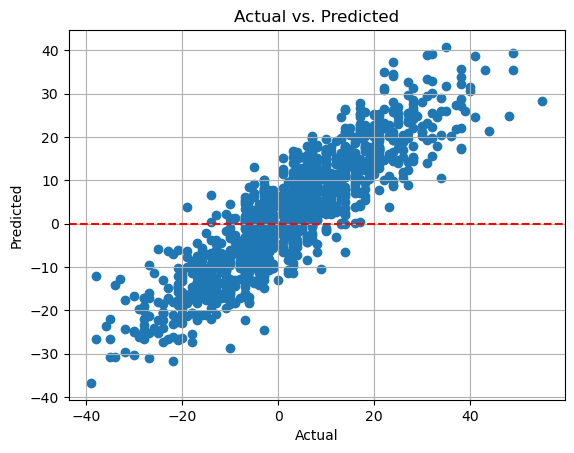

In [ ]:
plt.scatter(y_test, lasso_yhat)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Residuals vs Predicted')

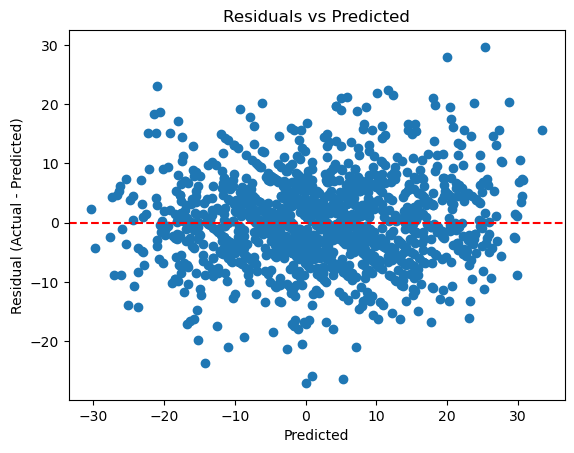

In [ ]:
residuals = y_test - yhat

plt.scatter(yhat, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")